In [1]:
import pandas as pd
import cv2
import numpy as np

import os

os.environ['CUDA_VISIBLE_DEVICES']='1'

In [2]:
folder='/udacity_images/'

In [3]:


def load(csv, correction,folder):
    df=pd.read_csv(folder+csv, skiprows=1,\
            names=['center','left','right','steering','trottle','brake','speed'])
    
    df['center']=df.center.apply(lambda x:x.split('/')[-1])
    df['left']=df.left.apply(lambda x:x.split('/')[-1])
    df['right']=df.right.apply(lambda x:x.split('/')[-1])

    images=np.empty((len(df)*6,160,320,3), dtype=np.uint8)
    target=np.empty((len(df))*6, dtype=np.float)

    #center
    for i,fname in enumerate(df['center'].values):
        images[i]=cv2.imread(folder+'IMG/'+fname.strip())

    #left
    for i,fname in enumerate(df['left'].values):
        images[i+len(df)]=cv2.imread(folder+'IMG/'+fname.strip())

    #right
    for i,fname in enumerate(df['right'].values):
        images[i+2*len(df)]=cv2.imread(folder+'IMG/'+fname.strip())

    target[0:len(df)]=df.steering.values
    target[len(df):2*len(df)]=df.steering.values+correction
    target[2*len(df):3*len(df)]=df.steering.values-correction

    target[3*len(df):6*len(df)]=-target[0:3*len(df)]

    for i in range(len(df)*3):
        images[i+3*len(df)]=np.fliplr(images[i])
        
    return images, target


In [4]:
X1, y1= load('driving_log.csv', 0.3,'/udacity_images/')

In [5]:
X2, y2= load('driving_log.csv', 0.3,'/notebooks/data/')

In [6]:
np.save('X',np.concatenate([X1,X2]))
np.save('y',np.concatenate([y1,y2]))

In [3]:
import numpy as np
X,y = np.load('X.npy'), np.load('y.npy')

In [7]:
from keras.models import Sequential
from keras.layers import Flatten,Dense, Convolution2D, Activation, MaxPooling2D, Lambda,Conv2D,Dropout, Cropping2D

Using TensorFlow backend.


In [8]:
from keras.callbacks import History,TensorBoard
history = History()

tb=TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False)

In [9]:
len(np.where((y2<0.05) & (y2>-0.05))[0]), len(y2)

(10522, 48216)

In [10]:
def rgb2yuv(x):
    tmp=np.zeros_like(x)
    tmp[:,:,0]=0.299*x[:,:,0]+0.587*x[:,:,1]+0.114*x[:,:,2]
    tmp[:,:,1]=-0.14713*x[:,:,0]-0.28886*x[:,:,1]+0.436*x[:,:,2]+128
    tmp[:,:,2]=0.612*x[:,:,0]-0.51499*x[:,:,1]-0.10001*x[:,:,2]+128
    
    return tmp

image=cv2.imread('/notebooks/data/IMG/center_2016_12_01_13_30_48_287.jpg')

tmp=rgb2yuv(image)

In [11]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D


# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
# let's add a fully-connected layer

x = Dense(1024, activation='relu')(x)
x = Dense(100, activation='relu')(x)
x = Dense(50, activation='relu')(x)
x = Dense(10, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(1)(x)

# this is the model we will train
model = Model(input=base_model.input, output=predictions)



/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [12]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(loss='mse',optimizer='adam')
# train the model on the new data for a few epochs


In [13]:
#model.compile(loss='mse',optimizer='adam')

In [15]:
model.fit(np.concatenate([X1,X2]), np.concatenate([y1,y2]), \
          validation_split=0.2, shuffle=True, epochs=25,batch_size=256,\
         callbacks=[history, tb])

ValueError: Error when checking model target: expected dense_5 to have 4 dimensions, but got array with shape (92544, 1)

In [ ]:
model.save_weights('model_inception')

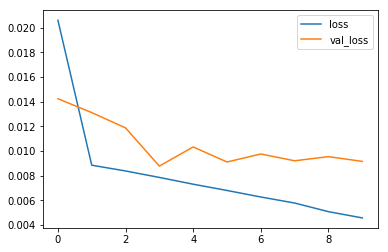

In [15]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')

plt.legend()
plt.show()

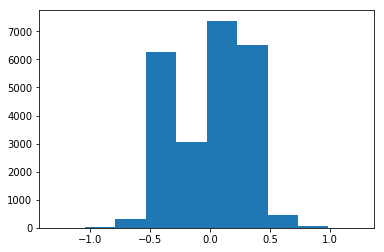

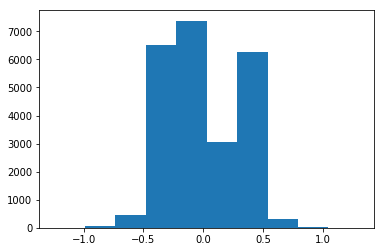

In [28]:
plt.hist(y2[24108:])
plt.show()

plt.hist(y2[:24108])
plt.show()

In [32]:
X2[0][0][0],X2[24108][0][-1]

(array([208, 163, 130], dtype=uint8), array([208, 163, 130], dtype=uint8))